In [0]:
!nvidia-smi

Sat Sep 14 20:30:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import os
from PIL import Image
import os
tf.enable_eager_execution()

Using TensorFlow backend.


In [0]:


epoch_number = 1000

PATH = "/content/drive/My Drive/Pix2Pix-Deblurrer"

INPATH = PATH + "/Blurred"

OUTPATH = PATH + "/not_blurred_resized"

img_id = os.listdir(INPATH)


n = 1000

train_n = int(round(n * 0.8))

rand_id = np.copy(img_id)
print(rand_id)

np.random.shuffle(rand_id)

train_id = rand_id[:train_n]
test_id = rand_id[train_n:n]
print(rand_id)
print(len(img_id), len(train_id), len(test_id))


['03357.jpg' '10957.jpg' '03780.jpg' ... '07775.jpg' '01595.jpg'
 '11228.jpg']
['10834.jpg' '10229.jpg' '11416.jpg' ... '00062.jpg' '00190.jpg'
 '02850.jpg']
11637 800 200


In [0]:

IMG_HEIGHT = 256
IMG_WIDTH = 256

def resize(in_img, og_img, height, width):
  in_img = tf.image.resize(in_img, [height, width])
  og_img = tf.image.resize(og_img, [height, width])
  
  return in_img, og_img


def normalize(in_img, og_img):
  in_img = (in_img / 127.5) - 1
  og_img = (og_img / 127.5) - 1
  
  return in_img, og_img



In [0]:

@tf.function()
def load_image(filename):
  in_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + "/" + filename)),tf.float32)[..., :3]
  og_img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + "/" + filename)),tf.float32)[..., :3]

  in_img, og_img = resize(in_img, og_img, IMG_HEIGHT,IMG_WIDTH)

  in_img, og_img = normalize(in_img, og_img)

  return in_img, og_img

@tf.function
def load_train_image(filename):
  
  return load_image(filename)



def load_test_image(filename):
  return load_image(filename)


In [0]:

train_dataset = tf.data.Dataset.from_tensor_slices(train_id)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=1)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(test_id)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=12)
test_dataset = test_dataset.batch(1)


In [0]:


from tensorflow.keras.layers import *
from tensorflow.keras import *
def downsample(filters, apply_batchnorm=True):
  
  result = Sequential()
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  result.add(Conv2D(filters,
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))
  
  if apply_batchnorm:
    result.add(BatchNormalization())
  
  result.add(LeakyReLU())
  
  return result


def upsample(filters, apply_dropout=False):
  global result
  result = Sequential()
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  result.add(Conv2DTranspose(filters,
                             kernel_size=4,
                             strides=2,
                             padding="same",
                             kernel_initializer=initializer,
                             use_bias=False))
  
  result.add(BatchNormalization())
  
  if apply_dropout:
    result.add(Dropout(0.5))
    
  result.add(ReLU())
  
  return result


In [0]:

def Generator():
  
  inputs = tf.keras.layers.Input(shape=[None,None,3])
  
  down_stack = [
      downsample(64, apply_batchnorm=False),
      downsample(128),
      downsample(256),
      downsample(512),
      downsample(512),
      downsample(512),
      downsample(512),
      downsample(512),
  ]

  up_stack = [
      upsample(512, apply_dropout=True),
      upsample(512, apply_dropout=True),
      upsample(512, apply_dropout=True),
      upsample(512),
      upsample(256),
      upsample(128),
      upsample(64),
  ]

  initializer = tf.random_normal_initializer(0, 0.02)

  last = Conv2DTranspose(filters=3,
                         kernel_size=4,
                         strides=2,
                         padding="same",
                         kernel_initializer = initializer,
                         activation = "tanh")
  
  x = inputs
  s = []

  concat = Concatenate()

  for down in down_stack:
    x = down(x)
    s.append(x)

  s = reversed(s[:-1])


  for up, sk in zip(up_stack, s):

    x = up(x)
    x = concat([x, sk])

  last = last(x)
  
  return Model(inputs=inputs, outputs=last)
  

generator = Generator()
 


In [0]:

def Discriminator():
  ini = Input(shape=[None, None, 3], name="input_img")
  gen = Input(shape=[None, None, 3], name="gener_img")

  con = concatenate([ini, gen])

  initializer = tf.random_normal_initializer(0, 0.02)

  down1 = downsample(64, apply_batchnorm=False)(con)
  down2 = downsample(128)(down1)
  down3 = downsample(256)(down2)
  down4 = downsample(512)(down3)

  last = tf.keras.layers.Conv2D(filters=1,
                                kernel_size=4,
                                strides=1,
                                kernel_initializer=initializer,
                                padding="same")(down4)




  return tf.keras.Model(inputs=[ini, gen], outputs=last)

discriminator = Discriminator()


loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:


def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  global total_gen_loss
  total_gen_loss = gan_loss + (100 * l1_loss)

  
  return total_gen_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [0]:


import os


checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

manager = tf.train.CheckpointManager(checkpoint, PATH+'/tf_ckpts', max_to_keep=3)


print(manager.checkpoints)

def generate_images(model, new_epoch,  test_input, tar, save_filename=True, display_img=True):
  prediction = model(test_input, training=True)

  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + "/output/" + save_filename + ".jpg", prediction[0,...])

  plt.figure(figsize=(10,10))
  display_list = [test_input[0], tar[0], prediction[0]]
  title = ["input Image", "Ground Truth", "Predicted Image"]

  if display_img:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis("off")

  plt.show
  plt.savefig(PATH + "/output_2/" + "Epoch-"+ new_epoch + "--" + str(imgi) + ".jpg")


['/content/drive/My Drive/Pix2Pix-Deblurrer/tf_ckpts/ckpt-225', '/content/drive/My Drive/Pix2Pix-Deblurrer/tf_ckpts/ckpt-226']


In [0]:


#@tf.function()
def train_step(input_image, target):
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

    output_image = generator(input_image, training=True)
    
    output_gen_discr = discriminator([output_image, input_image], training=True)

    output_target_discr = discriminator([target, input_image], training=True)

    discr_loss = discriminator_loss(output_target_discr, output_gen_discr)

    global gen_loss 
    
    gen_loss = generator_loss(output_gen_discr, output_image, target)


    generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

from IPython.display import clear_output

In [0]:


def train(dataset, epochs):
  

  for epoch in range(epochs-epoch_n):
    
    global imgi
    imgi = 0
    for input_image, target in dataset:
      train_step(input_image, target)
      new_epoch = str(epoch+epoch_n+1)
      print("epoch " + new_epoch + " - train: " + str(imgi) + "/"+str(len(train_id)) + " Loss = " + str(total_gen_loss.numpy()))
      imgi += 1
      

      clear_output(wait=True)
    imgi = 0
    for inp, tar in test_dataset.take(50):
      generate_images(generator, new_epoch, inp, tar, str(imgi) + "_" + str(epoch), display_img=True)
      imgi += 1
    save_path = manager.save()
    epoch_file = open(PATH+"/epochs.txt", "w")
    epoch_file.write(str(epoch+epoch_n))
    epoch_file.close()

KeyboardInterrupt: ignored

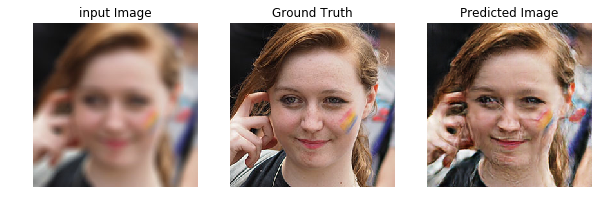

Error in callback <function flush_figures at 0x7f57ffd74ea0> (for post_execute):


KeyboardInterrupt: ignored

In [0]:


checkpoint.restore(manager.latest_checkpoint)
epoch_n = 0
print((open(PATH+"/epochs.txt", "r").read()))
if manager.latest_checkpoint:
  print("Restored from {}".format(manager.latest_checkpoint))
  epoch_n = int(open(PATH+"/epochs.txt", "r").read())
else:
  print("-----------------------------------------------Initializing from scratch.--------------------------------------------------------------------------")
train(train_dataset, epoch_number)

"Training complete"